## Análise da votação de preposições

In [1]:
import pandas as pd
import pandasql as ps
import numpy as np
import json, requests 
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

### Extração dos dados

Capturando as informações das proposicões votadas por tipo e ano

In [2]:
def getProposicoes(tipo, ano):
    url_votacoes = "https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ListarProposicoesVotadasEmPlenario?ano="+ano+"&tipo="+tipo
    response = requests.get(url_votacoes)
    dados_req = BeautifulSoup(response.content, 'html.parser')
    dados_req

    codproposicao = []
    nomeproposicao = []
    datavotacao = []
    for row in dados_req.findAll("proposicao"):
        codproposicao.append(row.find('codproposicao').text)
        nomeproposicao.append(row.find('nomeproposicao').text)
        datavotacao.append(row.find('datavotacao').text)

    tipoproposicao = []
    numeroproposicao = []
    anoproposicao = []
    for i in nomeproposicao:
        tipoproposicao.append(i.split(" ")[0])
        numeroproposicao.append(i.split(" ")[1].split("/")[0])
        anoproposicao.append(i.split(" ")[1].split("/")[1])

    proposicoes = pd.DataFrame()
    proposicoes['CodProposicao'] = codproposicao
    proposicoes['TipoProposicao'] = tipoproposicao
    proposicoes['NumeroProposicao'] = numeroproposicao
    proposicoes['AnoProposicao'] = anoproposicao
    proposicoes['DataVotacao'] = datavotacao
    return proposicoes


In [3]:
from pandasql import sqldf

def getQuery(q):
    pysqldf = lambda q: sqldf(q, globals())
    return pysqldf(q)


Capturando informações da orientação da bancada

In [4]:
# capturando informação da orientação da bancada
def orientacaoBancada(dadosxml, codsessao, varprop):
    dados = dadosxml.find('votacao', codsessao=codsessao)
    dataVotacao = dados.get('data')
    objVotacao = dados.get('objvotacao')
    proposicao = varprop
    
    bancada_codSessao = []
    bancada_proposicao = []
    bancada_objvotacao = []
    bancada_data = []
    bancada_partido = []
    bancada_orientacao = []
    
    for row in dados.findAll("orientacaobancada"):
        cells = row.findAll('bancada')
        for tag in cells:
            bancada_partido.append(tag.get('sigla'))
            bancada_orientacao.append(tag.get('orientacao'))
            bancada_objvotacao.append(objVotacao)
            bancada_data.append(dataVotacao)
            bancada_codSessao.append(codsessao)
            bancada_proposicao.append(proposicao)
    
    bancada = pd.DataFrame()
    bancada['CodSessao'] = bancada_codSessao
    bancada['Proposicao'] = bancada_proposicao
    bancada['Bancada'] = bancada_partido
    bancada['Orientacao'] = bancada_orientacao
    bancada['ObjVotacao'] = bancada_objvotacao
    bancada['DataVotacao'] = bancada_data
    return bancada


Capturando informações da votação dos parlamentares

In [5]:
# capturando informação da votação
def votosParlamentar(dadosxml, codsessao, varprop):
    dados = dadosxml.find('votacao', codsessao=codsessao)
    dataVotacao = dados.get('data')
    objVotacao = dados.get('objvotacao')
    proposicao = varprop
    
    dep_codSessao = []
    dep_objVotacao = []
    dep_proposicao =[]
    dep_id = []
    dep_data = []
    dep_nome = []
    dep_partido = []
    dep_uf = []
    dep_voto = []
    for row in dadosxml.findAll("votos"):
        cells = row.findAll('deputado')
        for tag in cells:
            dep_id.append(tag.get('idecadastro'))
            dep_nome.append(tag.get('nome'))
            dep_partido.append(tag.get('partido').replace(" ",""))
            dep_uf.append(tag.get('uf'))
            dep_voto.append(tag.get('voto').replace(" ",""))
            dep_codSessao.append(codsessao)
            dep_objVotacao.append(objVotacao)
            dep_data.append(dataVotacao)
            dep_proposicao.append(proposicao)
    
    votacao = pd.DataFrame()
    votacao['CodSessao'] = dep_codSessao
    votacao['Proposicao'] = dep_proposicao
    votacao['IdParlamentar'] = dep_id
    votacao['Parlamentar'] = dep_nome
    votacao['Partido'] = dep_partido
    votacao['Uf'] = dep_uf
    votacao['Voto'] = dep_voto
    votacao['ObjVotacao'] = dep_objVotacao
    votacao['Data'] = dep_data
    return votacao


Extraindo dados de Orientação da Bancada

In [6]:
def extraiVotosBancada(df_proposicoes):
    dfOrientacaoBancada = pd.DataFrame(columns=["CodSessao","Bancada","Orientacao","ObjVotacao","DataVotacao"])
    q="""SELECT DISTINCT CodProposicao, TipoProposicao, NumeroProposicao, AnoProposicao FROM proposicoes;"""
    df_proposicoes = getQuery(q)
    for x, y, z in zip(df_proposicoes['TipoProposicao'], df_proposicoes['NumeroProposicao'], df_proposicoes['AnoProposicao']):
        print("----------------")
        print(x,y,z)
        varprop = x + " " + y + " " + z
        url = "https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo="+x+"&numero="+y+"&ano="+z
        header = { 'Accept': 'application/xml' }
        response = requests.get(url)
        dadosxml = BeautifulSoup(response.content, 'html.parser')
        print(url)
        for votacao in dadosxml.findAll("votacoes"):
            linhas = votacao.findAll('votacao')
            for tag in linhas:
                print(tag.get('codsessao'), "-", tag.get('objvotacao'))

                df_orientacao = orientacaoBancada(dadosxml, tag.get('codsessao'), varprop)
                dfOrientacaoBancada = pd.concat([dfOrientacaoBancada, df_orientacao])
    return dfOrientacaoBancada

Extraindo os dados de Votação do Parlamentar

In [7]:
def extraiVotosParlamentar(proposicoes):
    dfVotosParlamentares = pd.DataFrame(columns=["CodSessao","IdParlamentar","Parlamentar","Partido","Uf","Voto","ObjVotacao","Data"])
    q="""SELECT DISTINCT CodProposicao, TipoProposicao, NumeroProposicao, AnoProposicao FROM proposicoes;"""
    df_proposicoes = getQuery(q)
    for x, y, z in zip(df_proposicoes['TipoProposicao'], df_proposicoes['NumeroProposicao'], df_proposicoes['AnoProposicao']):
        print("----------------")
        print(x,y,z)
        varprop = x + " " + y + " " + z
        url = "https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo="+x+"&numero="+y+"&ano="+z
        header = { 'Accept': 'application/xml' }
        response = requests.get(url)
        dadosxml = BeautifulSoup(response.content, 'html.parser')
        print(url)
        for votacao in dadosxml.findAll("votacoes"):
            linhas = votacao.findAll('votacao')
            for tag in linhas:
                print(tag.get('codsessao'), "-", tag.get('objvotacao'))

                df_votos = votosParlamentar(dadosxml, tag.get('codsessao'), varprop)
                dfVotosParlamentares = pd.concat([dfVotosParlamentares, df_votos])
    return dfVotosParlamentares

Extraindo os dados de Proposições

In [8]:
tipo = ["PEC", "MPV", "PLP", "PL"]
ano = "2019"
proposicoes = pd.DataFrame(columns=["CodProposicao","TipoProposicao","NumeroProposicao","AnoProposicao","DataVotacao"])
for t in tipo:
    proposicoes = pd.concat([proposicoes, getProposicoes(t, ano)])
print("Tipos:", tipo)
proposicoes.head()

Tipos: ['PEC', 'MPV', 'PLP', 'PL']


,CodProposicao,TipoProposicao,NumeroProposicao,AnoProposicao,DataVotacao
0,516111,PEC,70,2011,05/06/2019
1,516111,PEC,70,2011,05/06/2019
2,516111,PEC,70,2011,05/06/2019
3,946494,PEC,2,2015,26/03/2019
4,946494,PEC,2,2015,26/03/2019


In [9]:
dfVotosParlamentares = extraiVotosParlamentar(proposicoes)

----------------
PEC 70 2011
https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=PEC&numero=70&ano=2011
16828 - EMENDA AGLUTINATIVA Nº 1
16828 - PROPOSTA DE EMENDA À CONSTITUIÇÃO - 2º TURNO
16828 - EMENDA DE REDAÇÃO Nº 1
----------------
PEC 2 2015


/Users/Polato/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=PEC&numero=2&ano=2015
16761 - PROPOSTA DE EMENDA À CONSTITUIÇÃO - SEGUNDO TURNO
16761 - DTQ. 1 - BLOCO PSL - §11 DO ART. 165, CONST. DO ART. 1º DO SUBSTITUTIVO
16761 - DTQ. 2 - BLOCO PSL - EXP. "NOS TERMOS DE LEI COMPLEMENTAR", ...
16761 - SUBSTITUTIVO DA COMISSÃO ESPECIAL
16761 - EMENDAS DE REDAÇÃO DE NºS 1 A 4
----------------
PEC 372 2017
https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=PEC&numero=372&ano=2017
16955 - PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO TURNO
16983 - PROPOSTA DE EMENDA A CONSTITUIÇÃO - SEGUNDO TURNO
16983 - DTQ 1 - PL - EXP: "ALÉM DE OUTRAS ATRIBUIÇÕES..."
----------------
PEC 391 2017
https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=PEC&numero=391&ano=2017
17027 - EMENDA Nº 1
17027 - REQUERIMENTO DE RETIRADA DE PAUTA
17027 - PROPOSTA DE EMENDA À CONSTITUIÇÃO - PRIMEIRO TURNO
17027 - PROPOSTA DE EMENDA À CONS

16901 - REQUERIMENTO DE ADIAMENTO DA VOTAÇÃO POR 2 SESSÕES
16901 - REQUERIMENTO DE VOTAÇÃO ARTIGO POR ARTIGO
16902 - REQUERIMENTO DE RETIRADA DE PAUTA
----------------
MPV 881 2019
https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=MPV&numero=881&ano=2019
16894 - PARECER DA C.M P/ ATEND. DOS PRESSUPOSTOS CONSTITUCIONAIS...
16894 - REQUERIMENTO DE RETIRADA DE PAUTA
16893 - REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA
16896 - DTQ 5 - PSC - ART. 18 DO PLV À MP Nº 881/2019, QUE INCLUI ART. 82-A...
16894 - REQUERIMENTO DE ENCERRAMENTO DA DISCUSSÃO E DO ENCAMINHAMENTO
16896 - DTQ 8 - PT - §3º, ART. 74 DO DECRETO DE LEI Nº 5.452/1943...
16895 - DTQ 9 - PT - § 4º, ART. 50 DA LEI Nº 10.406/2002...
16895 - DTQ 10 - PT - ART. 70 DO DECRETO LEI Nº 5.452/1943...
16895 - DTQ 20 - PCdoB - ART. 68 CONTIDO NO ART. 28 DO PLV
16895 - DTQ 27 - PSOL - ART. 67 CONST. DO ART. 28 DO PLV
16894 - EMENDA AGLUTINATIVA Nº 1
16895 - EMA 4 - EMENDA AGLUTINATIVA Nº 4
16

16727 - REQUERIMENTO DE ADIAMENTO DA DISCUSSÃO POR 2 SESSÕES
----------------
PL 10985 2018
https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=PL&numero=10985&ano=2018
16845 - REQUERIMENTO DE VOTAÇÃO NOMINAL DO REQ. DE RETIRADA DE PAUTA
16845 - DTQ 4 - NOVO - ART. 3º DO PL 10.985/2018
16846 - DTQ 6 - PSL - ART. 4º DO PL 10.985/2018
----------------
PL 5029 2019
https://www.camara.leg.br/SitCamaraWS/Proposicoes.asmx/ObterVotacaoProposicao?tipo=PL&numero=5029&ano=2019
16930 - REQUERIMENTO DE RETIRADA DE PAUTA
16931 - REQUERIMENTO DE VOTAÇÃO DAS EMENDAS UMA A UMA
16931 - DTQ 1: NOVO - EMENDA SUPRESSIVA DO SENADO FEDERAL, QUE SUPRIMIU O ART. 44...
16930 - REQUERIMENTO DE ADIAMENTO DA DISCUSSÃO POR 2 SESSÕES
16931 - DTQ 2: PSL - EMENDA DO SENADO FEDERAL QUE SUPRIME O INCISO X DO ART. 44...
16931 - DTQ 3: PSL - EMENDA DO SENADO FEDERAL QUE SUPRIME O ART. 11 DA LEI Nº 9504/97
16931 - DTQ 4: PSL - EMENDA DO SENADO FEDERAL QUE SUPRIME O INCISO VIII DO ART. 44...


In [10]:
dfVotosParlamentares.head()

,CodSessao,Data,IdParlamentar,ObjVotacao,Parlamentar,Partido,Proposicao,Uf,Voto
0,16828,5/6/2019,141417,EMENDA AGLUTINATIVA Nº 1,Edio Lopes,PL,PEC 70 2011,RR,Sim
1,16828,5/6/2019,204465,EMENDA AGLUTINATIVA Nº 1,Haroldo Cathedral,PSD,PEC 70 2011,RR,Sim
2,16828,5/6/2019,178959,EMENDA AGLUTINATIVA Nº 1,Hiran Gonçalves,PP,PEC 70 2011,RR,Sim
3,16828,5/6/2019,160531,EMENDA AGLUTINATIVA Nº 1,Jhonatan de Jesus,PRB,PEC 70 2011,RR,-
4,16828,5/6/2019,204468,EMENDA AGLUTINATIVA Nº 1,Joenia Wapichana,REDE,PEC 70 2011,RR,Sim


### Pré Processamento

Diante da crise política de 2014, vários partidos mudaram de nome, símbolo e ideologia, tanto para atrair eleitores para as eleições de 2018, como também para se esquivar dos casos de corrupção envolvendo políticos desses partidos. Os nomes foram alterados, em muitos casos, para slogans, em vez de siglas. Também caiu a palavra "partido" em alguns casos de renomeação.

In [11]:
# Ajustando siglas de partidos
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PTN', 'PODEMOS', 'Podemos'], 'PODE')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PTDOB'], 'AVANTE')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PEN', 'PATRIOTA', 'Patriota'], 'PATRI')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PMDB'], 'MDB')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PSDC'], 'DC')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PR'], 'PL')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PBR', 'REPUBLICAN', 'Republican'], 'REPUBLICANOS')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['PPS'], 'CIDADANIA')
dfVotosParlamentares['Partido'] = dfVotosParlamentares['Partido'].replace(['SOLIDARIED', 'SOLIDARIEDAD', 'Solidariedad', 'Solidaried'], 'SOLIDARIEDADE')

### Análise dos dados

In [12]:
dfVotosParlamentares.groupby('Voto').count()

,CodSessao,Data,IdParlamentar,ObjVotacao,Parlamentar,Partido,Proposicao,Uf
Voto,,,,,,,,
-,505674,505674,505674,505674,505674,505674,505674,505674
Abstenção,5904,5904,5904,5904,5904,5904,5904,5904
Art.17,4223,4223,4223,4223,4223,4223,4223,4223
Não,861677,861677,861677,861677,861677,861677,861677,861677
Obstrução,153995,153995,153995,153995,153995,153995,153995,153995
Sim,808594,808594,808594,808594,808594,808594,808594,808594


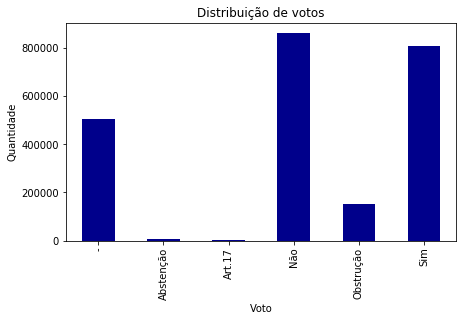

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
votos_tipo = dfVotosParlamentares.groupby('Voto').count().Partido
votos_tipo.plot(kind='bar', figsize=(7,4), grid=False, rot=90, color='darkblue')

plt.title('Distribuição de votos')
plt.xlabel('Voto')
plt.ylabel('Quantidade')
plt.show()

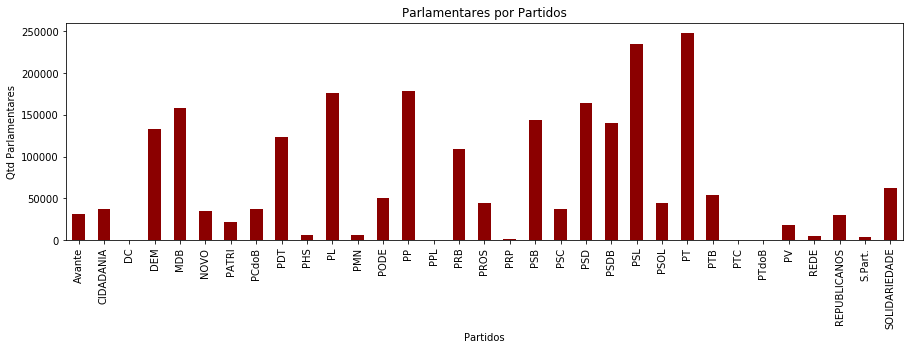

In [14]:
votos_partido = dfVotosParlamentares.groupby('Partido').count().Voto
votos_partido.plot(kind='bar', figsize=(15,4), grid=False, rot=90, color='darkred')

plt.title('Parlamentares por Partidos')
plt.xlabel('Partidos')
plt.ylabel('Qtd Parlamentares')
plt.show()

Verificando a quantidade de votantes por partido

In [15]:
df_analise = getQuery("SELECT DISTINCT Partido, Parlamentar from dfVotosParlamentares")
partido_parlamentar = getQuery("SELECT Partido, COUNT(*) AS Qtd_Parlamentares FROM df_analise GROUP BY Partido ORDER BY 2 DESC") 
partido_parlamentar

,Partido,Qtd_Parlamentares
0,MDB,134
1,PT,134
2,PSDB,108
3,DEM,103
4,PP,100
5,PL,93
6,PSB,65
7,PSL,65
8,PSD,56
9,PDT,54


### Cálculo da Coalisão Partidária através do Índice Rice

<p>Para medir a coesão partidária com base na análise das votações nominais será utilizado o Método de Rice (1925), já usado diversas vezes por vários estudiosos, muitos dos quais presentes na bibliografia.</p>
<p>O Índice Rice consiste em um cálculo simples que subtrai os votos sim e não, depois divididos pelo total de votos, excluindo as abstenções. Em um exemplo simples: se um partido A tiver 12 votos sim em um dada votação e 4 votos não, o cálculo ficará dessa forma: 12-4/16. O Índice Rice desse partido ficaria em 0,5. Quanto mais perto de 1,0, mais coeso o partido é; quanto mais próximo de 0, mais dividido.</p>
<p>Embora seja mais comum o cálculo da coesão para partidos políticos, outros grupos, como as frentes parlamentares, também podem ter sua medição a partir da metodologia anteriormente explicitada. Segundo o próprio Stuart Rice (1925), criador do índice, o cálculo foi elaborado para aferir coesão de grupos legislativos, não obrigatoriamente de partidos políticos. A importância de medir a coesão partidária a partir das votações nominais é justificada pelo autor quando afirma que “the most tangible and measurable units of political behavior are
votes” (Rice, 1925: 60).</p> 

In [16]:
df = pd.concat([dfVotosParlamentares, pd.get_dummies(dfVotosParlamentares.Voto)], 1).groupby(['ObjVotacao', 'Proposicao','Partido']).sum().reset_index()
rice = []
ano_base = []
for sim, nao in zip(df['Sim'], df['Não']):
    if(sim > nao):
        rice.append((sim-nao)/(sim+nao))
    elif(nao > sim):
        rice.append((nao-sim)/(sim+nao))
    else:
        rice.append(0)
df['Rice'] = rice
df.head()

,ObjVotacao,Proposicao,Partido,-,Abstenção,Art.17,Não,Obstrução,Sim,Rice
0,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,Avante,160.0,0.0,0.0,488.0,8.0,576.0,0.082707
1,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,CIDADANIA,168.0,4.0,0.0,560.0,28.0,648.0,0.072848
2,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,DEM,868.0,4.0,112.0,1632.0,80.0,2584.0,0.225806
3,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,MDB,976.0,8.0,0.0,1988.0,80.0,2932.0,0.191870
4,CONSULTA AO PLENÁRIO SOBRE VOTAÇÃO PARCELADA,PEC 6 2019,NOVO,32.0,0.0,0.0,584.0,28.0,764.0,0.133531


In [17]:
# Retirada da contagem sessões de votação que Canceladas
antes = df.shape[0]
df = getQuery("SELECT * FROM df WHERE ObjVotacao NOT LIKE '%CANCELAD%'")
print("Retiradas", (antes - df.shape[0]), "Sessões")

Retiradas 0 Sessões


In [18]:
df_coesao = pd.DataFrame(df.groupby(df['Partido']).mean()['Rice'])
df_coesao = df_coesao.reset_index()
ano_base = []
partido_upper = []
for linha in df_coesao['Partido']:
    ano_base.append(ano)
    partido_upper.append(linha.upper())
df_coesao['Ano'] = ano_base
df_coesao['Partido'] = partido_upper
df_coesao = df_coesao[['Ano', 'Partido', 'Rice']]
df_coesao

,Ano,Partido,Rice
0,2019,AVANTE,0.329583
1,2019,CIDADANIA,0.422710
2,2019,DC,0.458333
3,2019,DEM,0.417225
4,2019,MDB,0.388946
5,2019,NOVO,0.517449
6,2019,PATRI,0.414120
7,2019,PCDOB,0.548288
8,2019,PDT,0.405387
9,2019,PHS,0.314543


In [19]:
#df_coesao.to_csv('score/p_score_votos_2019.csv', sep=';', index=False)